# Accidentes de coches en Canada 

# Problema de clasificacion: Análisis descriptivo general

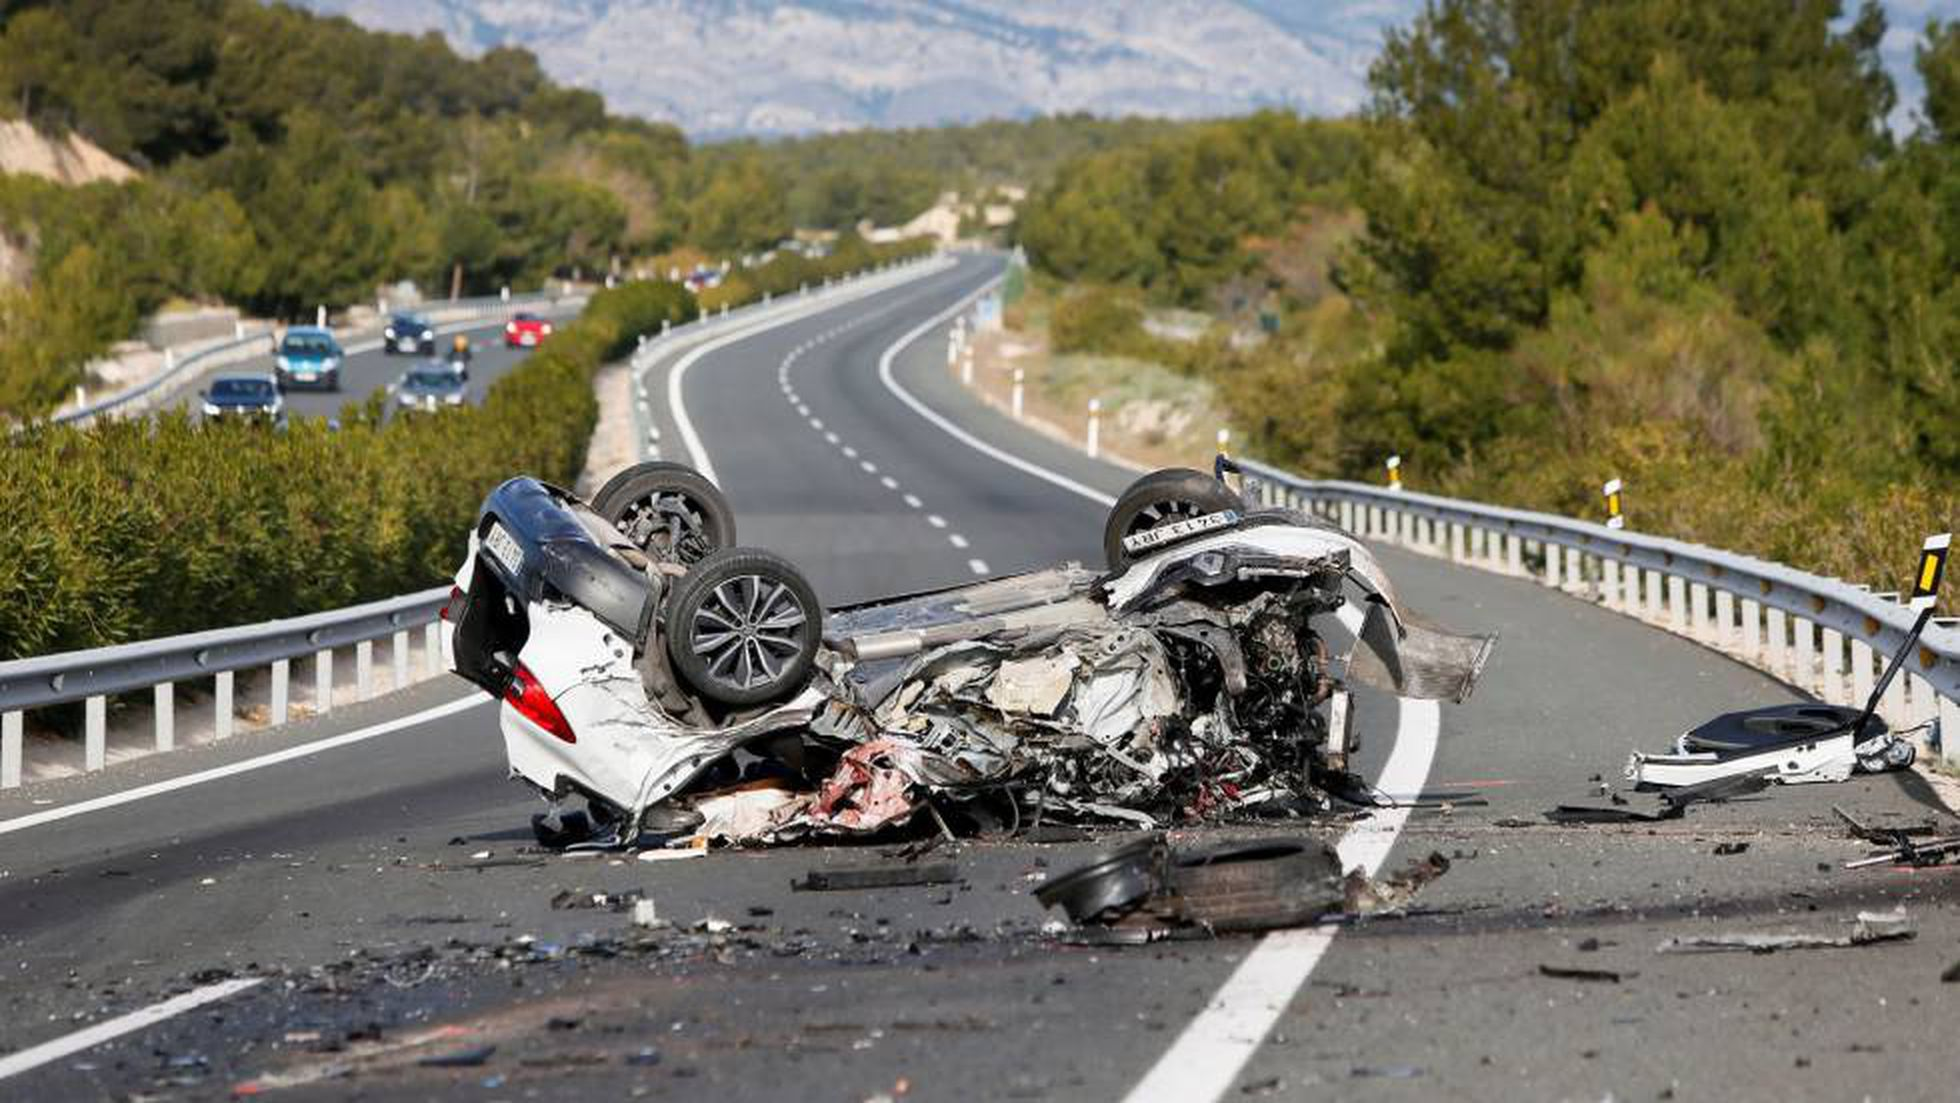

In [2]:
from PIL import Image
from IPython.display import display
from IPython.display import display, Image as IPImage

# Ruta de la imagen
ruta_imagen = 'fotocoche.jpg'

# Abrir la imagen
imagen = Image.open(ruta_imagen)

# Mostrar solo la imagen sin el código
display(IPImage(ruta_imagen))

Este conjunto de datos contiene datos de colisiones de accidentes automovilísticos en Canadá desde 1999 hasta 2014, proporcionados por Transport Canada. El objetivo principal es predecir si dado un accidente, este ha sido mortal o no a través de un modelo de clasificación. Aunque también nos interesa saber qué factores influyen más en la mortalidad de los accidentes y qué tipo de vehículos y conductores son más propensos a tener accidentes (acción correctiva en prima).

Algunas de las preguntas que estamos interesados en responder con el objetivo de conocer mejor nuestra base de datos:

1. ¿Qué tipos de vehículos (modelos, antigüedad, etc.) y conductores son más propensos a tener accidentes (acción correctiva en prima)?

2. ¿Qué tipos de vehículos (modelos, antigüedad, etc.) y conductores son menos propensos a tener accidentes (descuento en prima)?

3. ¿Qué es lo que más contribuye a que existan fallecimientos en un accidente?

4. Dado un accidente, ¿se puede generar un modelo que prediga si se va necesitar tratamiento médico o no? Las aseguradoras tienen que inmovilizar capital para pagar estas casuísticas. 



# Librerias 

In [3]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import seaborn as sns
import plotly.express as px
import scipy.stats as ss


import warnings
warnings.filterwarnings('ignore')

# Los Datos

In [4]:
df= pd.read_csv('NCDB_1999_to_2014.csv')
df.head()

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,...,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
0,1999,1,1,20,2,02,34,UU,1,5,...,01,06,1990,01,M,41,11,1,UU,1
1,1999,1,1,20,2,02,34,UU,1,5,...,02,01,1987,01,M,19,11,1,UU,1
2,1999,1,1,20,2,02,34,UU,1,5,...,02,01,1987,02,F,20,13,2,02,2
3,1999,1,1,08,2,01,01,UU,5,3,...,01,01,1986,01,M,46,11,1,UU,1
4,1999,1,1,08,2,01,01,UU,5,3,...,99,NN,NNNN,01,M,05,99,2,UU,3


In [5]:
print('Total de filas del dataset: ', len(df.index))

Total de filas del dataset:  5860405


In [6]:
print('Total de columnas del dataset: ', len(df.columns))

Total de columnas del dataset:  22


Descripcion de las variables : 
- year = año del accidente
- month = mes del accidente: de 1 a 12 ( UU o XX son missings)
- weekday = dia de la semana del accidente: de 1 a 7 ( U y X son missings)
- hour = hora del accidente : de 1 a 24 ( UU o XX son missings)
- fatality = accidente de gravedad (1), sin gravedad (2) , ( U y X son missings)
- vehicles_involved = numero de vehículos involucrados ( UU o XX son missings)
- crash_type = tipo de choque ( se podrian dividir en 4 categorias) ( UU, QQ y XX son missings)
- crash_place = sitio del accidente ( UU, QQ y XX son missings)
- crash_weather =  tiempo de 1 a 7 ( U, Q y X son missings)
- surface_state = condiciones del suelo de 1 a 9 ( U, Q y X son missings)
- road_slope = tipo de carretera ( U, Q y X son missings)
- traffic_state = estado del trafico de 1 a 18 ( UU, QQ y XX son missings)
- vehicle_id = tipo de vehiculo ( NN, UU, QQ y XX son missings)
- vehicle_year = año del modelo de coche ( NNNN, UUUU  y XXXX son missings)
- passenger_sex = sexo del pasajero ( U, N y X son missings)
- passenger_age = edad del pasajero ( UU, NN y XX son missings)
- passenger_role = sitio del pasajero ( NN, UU, QQ y XX son missings)
- passenger_fatality = mide la gravedad del accidente para el pasajero ( 3 es fallecimiento) ( U, N y X son missings)
- passenger_safety = Indica si en el momento del accidente el pasajero estaba protegido por ejemplo cinturon o casco ( NN, UU, QQ y XX son missings)
- passenger_type = tipo de pasagero ( U es missing)



In [7]:
# cambiamos de nombre a las variables para que sea mas facil identificarlas

In [5]:
new_names = ["year", "month", "weekday", "hour", "fatality", "vehicles_involved", "crash_type", "crash_place", "crash_weather",
"surface_state", "road_slope", "traffic_state", "vehicle_id", "vehicle_type", "vehicle_year", "passenger_id", "passenger_sex",
"passenger_age", "passenger_role", "passenger_fatality", "passenger_safety", "passenger_type"]

df.columns = new_names

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5860405 entries, 0 to 5860404
Data columns (total 22 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   year                int64 
 1   month               object
 2   weekday             object
 3   hour                object
 4   fatality            int64 
 5   vehicles_involved   object
 6   crash_type          object
 7   crash_place         object
 8   crash_weather       object
 9   surface_state       object
 10  road_slope          object
 11  traffic_state       object
 12  vehicle_id          object
 13  vehicle_type        object
 14  vehicle_year        object
 15  passenger_id        object
 16  passenger_sex       object
 17  passenger_age       object
 18  passenger_role      object
 19  passenger_fatality  object
 20  passenger_safety    object
 21  passenger_type      object
dtypes: int64(2), object(20)
memory usage: 983.6+ MB


Podemos observar que la mayoría de columnas son tratados como object. En un primer vistazo con la función head ha mostrado que en su mayoría se corresponden con valores enteros, los que sabemos, por el diccionario de datos elaborado, se refieren a categorías. Un estudio más detenido de los datos nos enseña la existencia de valores especiales que justifican la lectura de estas columnas como object, los cuales estudiamos a continuación.

In [10]:
for col in df.columns:
    print(col)
    print(df[col].unique())
    if (col != 'P_USER'): 
        print('-------------------------')

year
[1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014]
-------------------------
month
[1 2 3 4 5 6 7 8 9 10 11 12 '12' 'UU' '01' '02' '11']
-------------------------
weekday
[1 2 3 4 5 6 7 '7' 'U' '1' '2' '3' '4' '5' '6']
-------------------------
hour
['20' '08' '17' '15' '14' '01' '11' '13' '19' '16' '09' '02' '18' '12'
 '10' '23' '00' '06' '07' '21' 'UU' '05' '22' '03' '04']
-------------------------
fatality
[2 1]
-------------------------
vehicles_involved
['02' '01' '03' '04' '06' '07' '09' 'UU' '05' '13' '08' '12' '14' '10'
 '11' '16' 1 2 3 4 5 6 8 7 12 10 '26' '71' 19 25 9 '21' '27' '15' '35' 15
 13 26 '22' '41' 27 46 31 11 '18' 18 56 '23' 36 17 14 20 21 '19' 16 '29'
 '25' 77 28 38 '38' '17' '32' 35 22 33 '54' 72 '40' 44 58 '30' '77' '20'
 '24' '34' 24 nan 39 '51' 57 43 37]
-------------------------
crash_type
['34' '01' 'QQ' '04' '31' '21' '23' '03' '02' '33' 'UU' '24' '35' '41'
 '06' '32' '36' '05' '22' '25']
-------------------------
crash_p

## Eliminacion duplicados

In [11]:
print(df.shape)

(5860405, 22)


In [6]:
# quitamos los datos duplicados 
df = df.drop_duplicates()
print(df.shape)

(5855336, 22)


## Transformacion variable Fatality

In [7]:
# Antes: 1-fatality 2-no fatality
# Después: 1-fatality 0-no fatality

df['fatality'] = df['fatality'].replace({2:0})

#Ponemos la variable objetivo a la derecha del dataframe
new_columns = list(df.columns[0:4]) + list(df.columns[5:]) + list(df.columns[4:5])
df = df[new_columns]
df.head()

,year,month,weekday,hour,vehicles_involved,crash_type,crash_place,crash_weather,surface_state,road_slope,...,vehicle_type,vehicle_year,passenger_id,passenger_sex,passenger_age,passenger_role,passenger_fatality,passenger_safety,passenger_type,fatality
0,1999,1,1,20,02,34,UU,1,5,3,...,06,1990,01,M,41,11,1,UU,1,0
1,1999,1,1,20,02,34,UU,1,5,3,...,01,1987,01,M,19,11,1,UU,1,0
2,1999,1,1,20,02,34,UU,1,5,3,...,01,1987,02,F,20,13,2,02,2,0
3,1999,1,1,08,01,01,UU,5,3,6,...,01,1986,01,M,46,11,1,UU,1,0
4,1999,1,1,08,01,01,UU,5,3,6,...,NN,NNNN,01,M,05,99,2,UU,3,0


## Analisis de valores nulos Q, N, U y X

En el diccionario de datos encontramos varios tipos de datos ausentes. 

* Q: Este valor indica que se corresponde con una categoría distinta a las demás.
* N: Este valor indica que el criterio de valoración no es aplicable. Este se corresponde generalmente, con tuplas que son valores dummies y por lo tanto no necesita esta información.
* U: Este valor indica que se desconoce, un valor faltante.
* X: Este valor indica que el valor está clasificado y no ha sido proporcionado.

Principalmente U, UU y UUUU que son datos estrictamente desconocidos.

Como podemos ver arriba, no todos esos valores estan presentes en todas las variables.

In [14]:
def calcular_datos_faltantes(df):
    vals_hists = [['Q', 'QQ', 'QQQQ'], ['N', 'NN', 'NNNN'], ['U', 'UU', 'UUUU'], ['X', 'XX', 'XXXX']]
    datos_faltantes = {}
    total_registros = len(df)

    for columna in df.columns:
        datos_faltantes[columna] = {}

        for valores in vals_hists:
            datos_faltantes[columna][valores[0]] = df[columna].isin(valores).sum()
        
        datos_faltantes[columna]['Porcentaje'] = (sum(datos_faltantes[columna].values()) / total_registros) * 100 

    return pd.DataFrame(datos_faltantes)

# Ejemplo de uso
datos_faltantes_df = calcular_datos_faltantes(df)
datos_faltantes_df.T


,Q,N,U,X,Porcentaje
year,0.0,0.0,0.0,0.0,0.000000
month,0.0,0.0,385.0,0.0,0.006575
weekday,0.0,0.0,1323.0,0.0,0.022595
hour,0.0,0.0,59404.0,0.0,1.014528
vehicles_involved,0.0,0.0,541.0,0.0,0.009239
crash_type,284942.0,0.0,178785.0,0.0,7.919733
crash_place,144273.0,0.0,504547.0,0.0,11.080833
crash_weather,15010.0,0.0,87953.0,0.0,1.758447
surface_state,170196.0,0.0,78433.0,0.0,4.246195
road_slope,28597.0,0.0,434626.0,0.0,7.911126


Nuestra posible variable de estudio 'fatality' no tiene datos faltantes por lo que podemos afirmar que esta sera nuestra variable de estudio. Ademas, las variables que tienen mayor porcentaje de datos faltantes son passenger_safety (21%), crash_place (11%), vehicle_year (10%).

Ahora comprobamos que no haya Na, si los hay los quitamos:

In [15]:
df.isnull().sum()

year                  0
month                 0
weekday               0
hour                  0
vehicles_involved     3
crash_type            0
crash_place           0
crash_weather         0
surface_state         0
road_slope            0
traffic_state         0
vehicle_id            0
vehicle_type          0
vehicle_year          0
passenger_id          0
passenger_sex         0
passenger_age         0
passenger_role        0
passenger_fatality    0
passenger_safety      0
passenger_type        0
fatality              0
dtype: int64

In [8]:
# quitamos los valores nulos 
df = df.dropna()
print(df.shape)

(5855333, 22)


Vamos a dividir el estudio de los missings por filas y columnas:

## Transformacion del dataset

Como venimos indicando, la variable de estudio 'fatality' hace referencia a la siniestralidad del accidente.Por tanto, no nos interesa saber tantos datos de los pasajeros del accidente. Si que nos interesa saber el numero de personas implicadas y las caracteristicas del conductor o conductores. Vamos a hacer una tranformacion del dataset para quedarnos solo con las variables que nos interesan: 

In [17]:
acc_columns = ["year", "month", "weekday", "hour", "fatality", "vehicles_involved", "crash_type", "crash_place", "crash_weather",
"surface_state", "road_slope", "traffic_state"]

acc_group_df = df.groupby(acc_columns).size().reset_index(name='n_personas_implicadas')


In [18]:
acc_group_df

,year,month,weekday,hour,fatality,vehicles_involved,crash_type,crash_place,crash_weather,surface_state,road_slope,traffic_state,n_personas_implicadas
0,1999,1,1,00,0,01,01,01,1,4,1,18,1
1,1999,1,1,00,0,01,01,01,1,5,1,18,1
2,1999,1,1,00,0,01,01,01,2,1,1,18,1
3,1999,1,1,00,0,01,01,01,6,3,2,18,2
4,1999,1,1,00,0,01,01,UU,1,2,3,18,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1856903,2014,12,7,UU,0,02,UU,02,U,U,1,03,2
1856904,2014,UU,U,14,0,01,02,01,1,5,4,18,1
1856905,2014,UU,U,22,1,01,06,01,2,4,Q,18,2
1856906,2014,UU,U,23,0,01,06,05,1,1,U,18,1


## Transformacion de la variable año del coche ---> edad del coche

In [9]:
# Transformamos la variable vehicle_year a años de antigüedad 
df['vehicle_year'] = pd.to_numeric(df.year - pd.to_numeric(df.vehicle_year, errors= "coerce"))
df = df.rename(columns={"vehicle_year": 'vehicle_age'})

## Estudio de la variable a predecir: fatality

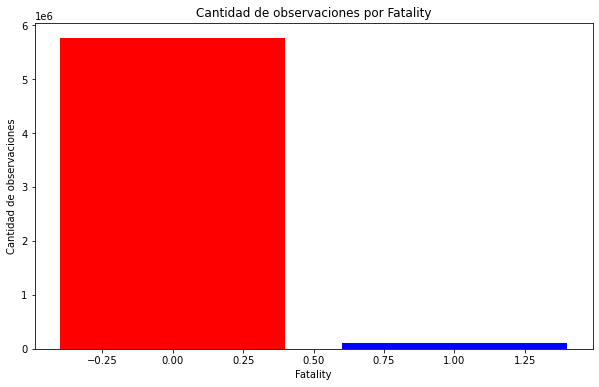

In [20]:
# Plot variable 'fatality'

# Contar la cantidad de observaciones de cada categoría
conteo_fatality = df['fatality'].value_counts()

plt.figure(figsize=(10, 6))  # Tamaño del gráfico (ancho, alto)
plt.bar(conteo_fatality.index, conteo_fatality.values, color=['red', 'blue'])

# Personalizar el gráfico
plt.xlabel('Fatality')
plt.ylabel('Cantidad de observaciones')
plt.title('Cantidad de observaciones por Fatality')

# Mostrar el gráfico
plt.show()


In [21]:
porcentaje_0 = (df['fatality'].value_counts()[0] / len(df)) * 100
# Imprimir el resultado
print("Porcentaje de accidentes no mortales en la variable 'fatality': {:.2f}%".format(porcentaje_0))
print( '----- El dataset esta desbalanceado -----')

Porcentaje de accidentes no mortales en la variable 'fatality': 98.32%
----- El dataset esta desbalanceado -----


## Estudio del resto de variables.

### Variables continuas

Tenemos cuatro variables continuas: year, vehicles_involved, passenger_age y vehicle_year. Estas tres ultimas necesitamos tranformarlas porque son tipo objeto. Pero tenemos en cuenta los valores missings:

In [15]:
# Conversión parcial
numeric_var = ['year', 'vehicles_involved', 'vehicle_age', 'passenger_age']
accidents_temp = df

# Valores especiales
Q = ['Q', 'QQ', 'QQQQ']
N = ['N', 'NN', 'NNNN']
U = ['U', 'UU', 'UUUU']
X = ['X', 'XX', 'XXXX']
vals_hist = [Q, N, U, X]

for val in vals_hist: 
    accidents_temp = accidents_temp.replace(val, np.nan)

accidents_temp[numeric_var] = accidents_temp[numeric_var].astype(float)

<AxesSubplot:>

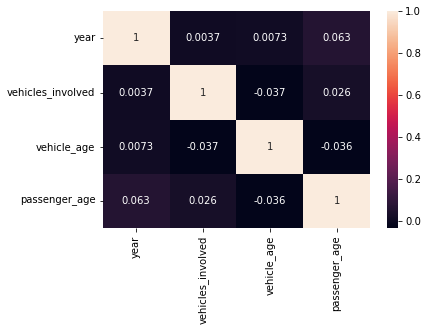

In [24]:
correlation = accidents_temp[numeric_var].corr()
sns.heatmap(correlation, annot=True)

Podemos observar las variables en general estan incorreladas.

In [25]:
accidents_temp.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,year,vehicles_involved,vehicle_age,passenger_age,fatality
count,5.85533e+06,5.85479e+06,5.27216e+06,5.4611e+06,5.85533e+06
mean,2006,2.04581,7.47724,36.3991,0.0168421
std,4.5697,1.26915,5.50259,18.3696,0.12868
min,1999,1,-2,1,0
25%,2002,2,3,22,0
50%,2006,2,7,34,0
75%,2010,2,11,49,0
max,2014,77,103,99,1


Destacamos que existe un accidente con 77 vehículos implicados, es posible que se trate de un accidente múltiple o un autobus. Y también observamos un registro extraño: En vehicle_age existen vehículos con 103 años o con -2. El registro -2 es claramente un error ya que no puede haber coches fabricados despues de tener el accidente.

In [26]:
# quitar obs que tengan  df['vehicle_year'] == '2015'
df = df[df['vehicle_age'] != '-2']

### Variables categoricas

Recordamos que al analizar la variable objetivo esta estaba desbalanceada. 

In [11]:
def norm_category(df, objetivo, categorica):    
    # Agrupamos y contamos las ocurrencias de las categorías en función de la variable objetivo.
    grouped = df.groupby([objetivo, categorica]).count().iloc[:,1]
    grouped = grouped.reset_index()
    grouped.columns = [objetivo, categorica, 'counted']
    
    # Calculamos el porcentaje para cada grupo (variable objetivo) del total de elementos de dicha categoría (subgrupo)
    grouped['group%'] = np.round(grouped['counted'] / 
                                 grouped.groupby(objetivo)['counted'].transform('sum') * 100, decimals = 3)
    return grouped

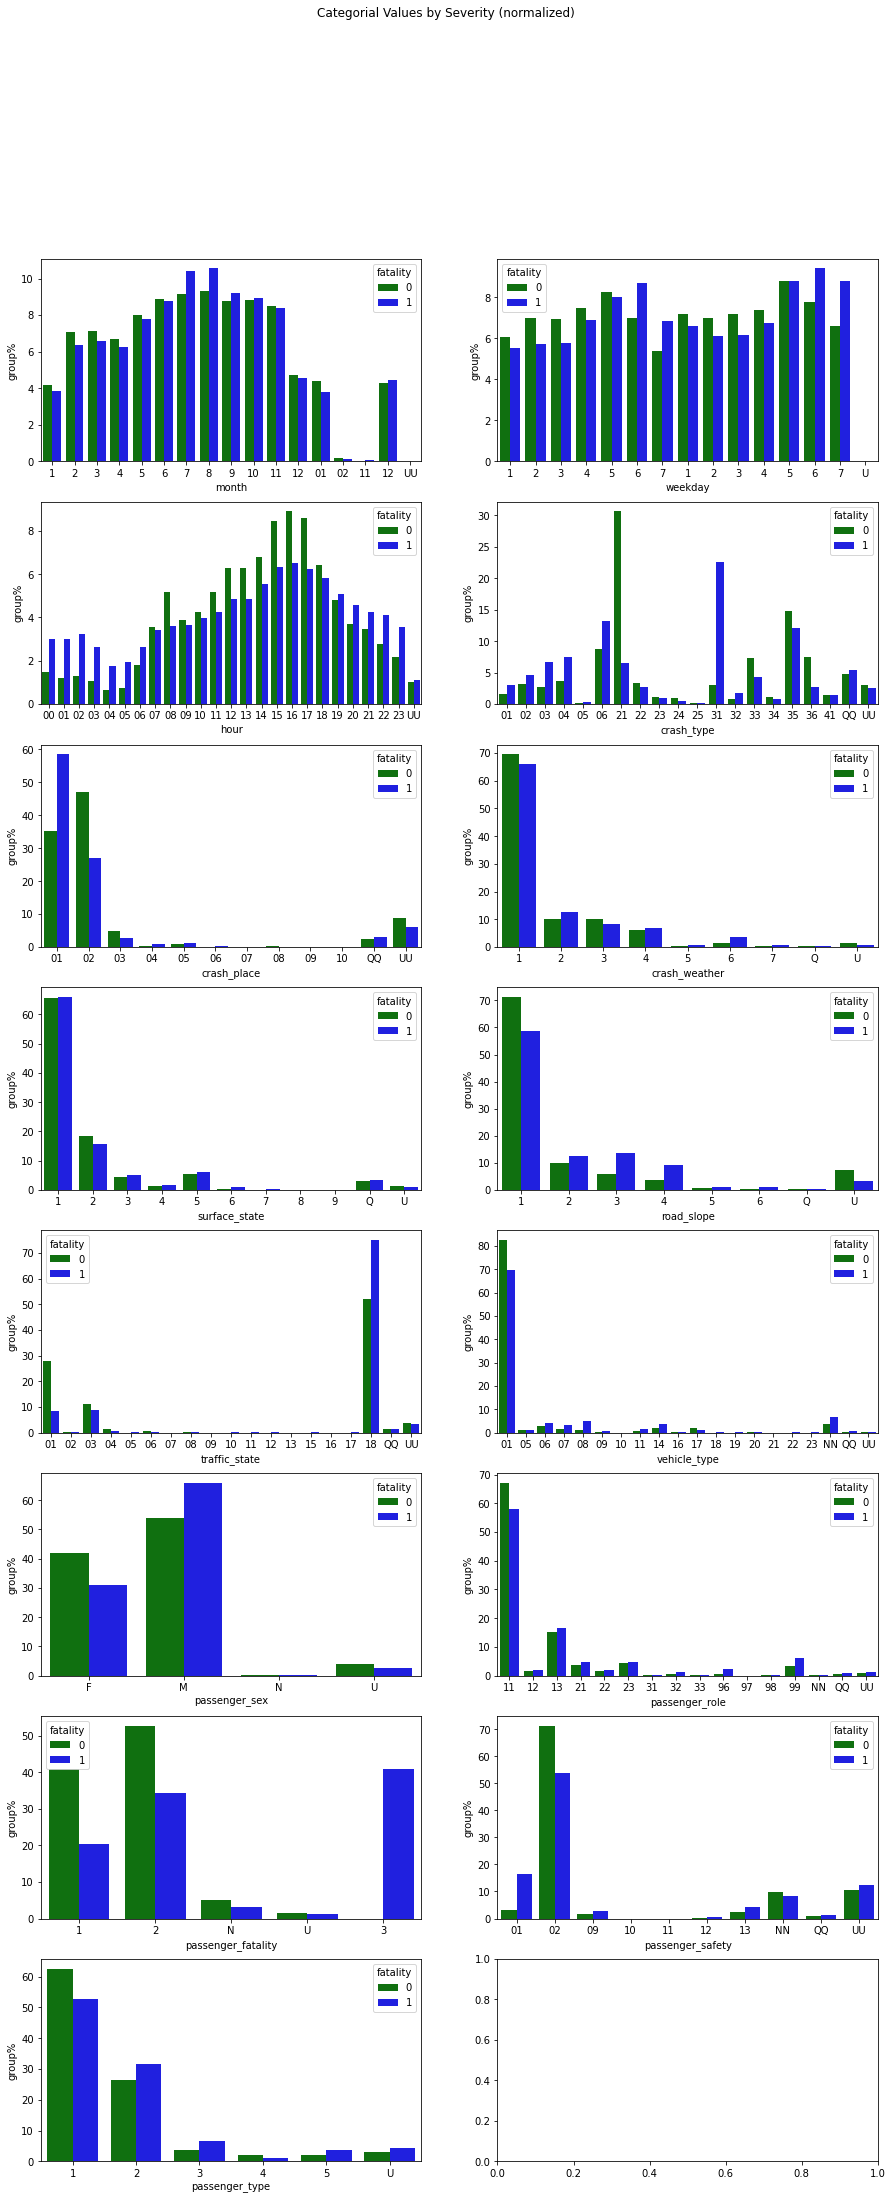

In [16]:
categorical = ["month", "weekday", "hour", "crash_type", "crash_place", "crash_weather",
"surface_state", "road_slope", "traffic_state","vehicle_type", "passenger_sex", "passenger_role", "passenger_fatality", "passenger_safety", "passenger_type"]

fig, axes = plt.subplots(8, 2, figsize=(15, 35), sharey=False)
fig.suptitle('Categorial Values by Severity (normalized)')

i = 0 # fila del dibujo
j = 0 # columna del dibujo

# Impresión de cada categoría
for cat in categorical:
    # Normalizamos la categoría para que sea visulamente interpretable
    temp = norm_category(df = df, objetivo = 'fatality', categorica = cat)
    # Creamos la gráfica
    sns.barplot(data = temp, x = cat, y = 'group%', hue = 'fatality', palette=['green', 'blue'],ax = axes[i,j]);
    
    # Modificamos los índices de las gráficas para su dibujo
    if (j == 0): 
        j = 1
    else:
        j = 0
        i += 1

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5855333 entries, 0 to 5860404
Data columns (total 22 columns):
 #   Column              Dtype  
---  ------              -----  
 0   year                int64  
 1   month               object 
 2   weekday             object 
 3   hour                object 
 4   vehicles_involved   object 
 5   crash_type          object 
 6   crash_place         object 
 7   crash_weather       object 
 8   surface_state       object 
 9   road_slope          object 
 10  traffic_state       object 
 11  vehicle_id          object 
 12  vehicle_type        object 
 13  vehicle_age         float64
 14  passenger_id        object 
 15  passenger_sex       object 
 16  passenger_age       object 
 17  passenger_role      object 
 18  passenger_fatality  object 
 19  passenger_safety    object 
 20  passenger_type      object 
 21  fatality            int64  
dtypes: float64(1), int64(2), object(19)
memory usage: 1.1+ GB


# Preguntas 

## ¿Qué tipos de vehículos y conductores son más propensos a tener accidentes ?

<AxesSubplot:>

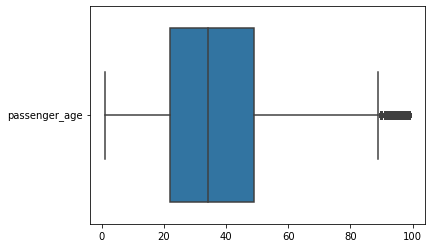

In [ ]:
sns.boxplot(data=accidents_temp[['passenger_age']].dropna(), orient="h")

Podemos ver en este boxplot de la variable edad del pasajero que existen muchos outliers a la derecha de la gráfica. Además, la 'caja' que nos indica donde se encuentran la mayor parte de las observaciones, nos indica que la distribucion esta muy centrada en la edad de 20-45 años.

Como sabemos, la mayor parte de los accidentes de coches se dan entre la gente joven (cuando los conductores son noveles y tienen poca experiencia) y es menos frecuente encontrar accidentes en los que la persona tenga una edad media (>50 años).

Ademas de los graficos anteriores tenemos:
* Los hombres suelen tener mas accidentes y ademas tienen mas probabilidad de ser mortales.
* En cuanto al tipo de vehiculos, suelen ser coches y camionetas.
* Los meses de verano y las horas de despues de la comida son los momentos mas propensos a accidentes.
* Ademas en cuanto al estado de la carretera, algo que sorprende es que se dan mas accidentes en clima soleado, carretera seca y recta.

## ¿Qué es lo que más contribuye a que existan fallecimientos en un accidente?

Lo que mas influye a la hora de hablar de accidentes graves con fallecidos es: 
* Observamos que el tipo de accidente afecta a la mortalidad del mismo. Por ejemplo los accidentes frontales tienen un elevado porcentaje de mortalidad.

* La señalización o nivel de seguridad existente en la carretera. Cuando no existe esta señalización es altamente probable que el accidente cause muertos.

* Por otro lado el tiempo cuando ocurre el accidente contribuye en cierta manera. Fines de semana y verano son en los que existe una probabilidad elevada de accidentes mortales. En cuanto a las horas, es necesario señalar que los accidentes que ocurren de madrugada son altamente mortales.


## Dado un accidente, ¿se puede generar un modelo que prediga si se va necesitar tratamiento médico o no? 

Aunque como hemos dicho anteriormente, nuestro objetivo es tratar de averiguar si un accidente sera mortal o no (al menos para una persona involucrada en el accidente), tambien podemos estar interesados como aseguradora, si dado un accidente se va a necesitar ayuda medica. 

Podriamos tomar la variable passenger_fatality ( ileso, herido o fallecido) como la variable objetivo del modelo. Asumiendo que si se está herido se requiere de un tratamiento médico y eliminando los datos referentes a fallecidos, de manera que el modelo ofrezca una clasificación binaria.

Para ello, necesitamos conocer, no sólo los datos del accidente a nivel general, sino también otra información más detallada, relativa a la persona en ese accidente ya que dependera de las caracteristicas del pasajero. Esto es, todo el conjunto de datos. 

# Nuestro modelo

Finalmente, para predecir la variable 'fatality' nuestor conjunto de datos estará formado por los datos relativos al accidente : 
*  year                 
* month                
* weekday              
* hour                 
* vehicles_involved  
* crash_type          
* crash_place         
* crash_weather       
* surface_state       
* road_slope          
* traffic_state       
* vehicle_type

y la variable que hemos inventado de el numero de personas implicadas en el accidente.   